# Fair Market Rates analysis tool

In [1]:
import fetchData
import transformData
import pandas as pd
import analyze

## Data Preparation

In [2]:
API_file = 'API_Config.ini'
BLS_area_codes = 'Data/BLS/cu.area.txt'
analysis_start_year = 2014
analysis_end_year = 2024
FMR_implementation_month = 10

### Loading the list of metro areas from BLS

Loading the list of metro areas whose CPI data is present in the Bureau of Labour Statistics database

In [4]:
#fetching series id's for every metro area available in the Bureau of Labour Statistic's database
series_id = fetchData.get_bls_series_id(metro_code_file=BLS_area_codes)
series_id

,area_code,area_name,area_state
1,CUURS11ASA0,Boston-Cambridge-Newton,MA-NH
2,CUURS12ASA0,New York-Newark-Jersey City,NY-NJ-PA
3,CUURS12BSA0,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD
5,CUURS23ASA0,Chicago-Naperville-Elgin,IL-IN-WI
6,CUURS23BSA0,Detroit-Warren-Dearborn,MI
7,CUURS24ASA0,Minneapolis-St.Paul-Bloomington,MN-WI
8,CUURS24BSA0,St. Louis,MO-IL
10,CUURS35ASA0,Washington-Arlington-Alexandria,DC-VA-MD-WV
11,CUURS35BSA0,Miami-Fort Lauderdale-West Palm Beach,FL
12,CUURS35CSA0,Atlanta-Sandy Springs-Roswell,GA


In [5]:
series_id.isna().sum()

area_code     0
area_name     0
area_state    0
dtype: int64

The dataset has no missing values

#### Cleaning the CPI Data

In [6]:
series_id['area_state'].unique()

<StringArray>
[      'MA-NH',    'NY-NJ-PA', 'PA-NJ-DE-MD',    'IL-IN-WI',          'MI',
       'MN-WI',       'MO-IL', 'DC-VA-MD-WV',          'FL',          'GA',
          'MD',          'TX',          'AZ',          'CO',          'CA',
          'WA',      'Hawaii',      'Alaska']
Length: 18, dtype: string

On further inspection, there are some rows for which the state names [Hawaii and Alaska] are not abbreviated. This can later cause an issue while merging this dataset with the HUD dataset.

In [7]:
series_id.loc[series_id['area_state'] == 'Hawaii','area_state'] = 'HI'
series_id.loc[series_id['area_state'] == 'Alaska','area_state'] = 'AK'
series_id['area_state'].unique()

<StringArray>
[      'MA-NH',    'NY-NJ-PA', 'PA-NJ-DE-MD',    'IL-IN-WI',          'MI',
       'MN-WI',       'MO-IL', 'DC-VA-MD-WV',          'FL',          'GA',
          'MD',          'TX',          'AZ',          'CO',          'CA',
          'WA',          'HI',          'AK']
Length: 18, dtype: string

After processing, the dataframe has no missing / incorrect values.

### Loading the list of metro areas from HUD

Loading the list of metro areas whose FMR data is available in the HUD database

In [8]:
hud_metro_data = fetchData.get_metro_codes_hud(api_config=API_file)
hud_metro_data.head()

,cbsa_code,area_name,area_state
0,METRO10180M10180,Abilene,TX
1,METRO29180N22001,Acadia Parish,LA
2,METRO10380M10380,Aguadilla-Isabela,PR
3,METRO10420M10420,Akron,OH
4,METRO10500M10500,Albany,GA


In [9]:
hud_metro_data.isna().sum()

cbsa_code     0
area_name     0
area_state    0
dtype: int64

This dataset has no missing values.

#### Cleaning the FMR data

In [11]:
hud_metro_data['area_state'].unique()

<StringArray>
[          'TX',           'LA',           'PR',           'OH',
           'GA',           'OR',           'NY',           'NM',
           'KY',           'PA',           'IA',           'AK',
           'IN',           'SC',           'MI',           'AL',
           'WI',           'NC',           'NJ',        'GA-SC',
           'FL',           'CA',           'MD',           'ME',
           'MA',           'MO',           'WA',           'MS',
           'MT',           'ND',           'VA',           'IL',
           'ID',           'WV',        'MA-NH',           'CO',
           'UT',           'CT',           'VT',           'TN',
        'MO-IL',           'NV',           'WY',        'NC-SC',
        'TN-GA',     'OH-KY-IN',        'TN-KY',        'GA-AL',
           'OK',        'MD-WV',           'SD',        'IA-IL',
           'DE',        'MN-WI',        'IN-KY',        'ND-MN',
           'AR',           'MN',           'AZ',        'AR-OK',
           

On further inspection, there is a row for which the state name [TX-Texarkana] is not correct. This can later cause an issue while merging this dataset with the BLS dataset.

In [12]:
hud_metro_data.loc[hud_metro_data['area_state'] == 'TX-Texarkana', 'area_state'] = 'TX'

After processing, the dataframe has no missing / incorrect values.

### Merging the BLS and HUD datasets

Merging the two datasets to get the metro areas for which both the CPI and FMR data is available.

In [13]:
merge_data = pd.merge(series_id, hud_metro_data, on='area_name', how='left', suffixes=('_BLS', '_HUD'))
merge_data.isna().sum()

area_code          0
area_name          0
area_state_BLS     0
cbsa_code         12
area_state_HUD    12
dtype: int64

There are 12 rows from the BLS dataset that have no corresponding metro area in the HUD dataset. Ideally that should not be the case, HUD's database is quite extensive.

In [14]:
merge_data[merge_data['cbsa_code'].isna()]

,area_code,area_name,area_state_BLS,cbsa_code,area_state_HUD
0,CUURS11ASA0,Boston-Cambridge-Newton,MA-NH,<NA>,<NA>
1,CUURS12ASA0,New York-Newark-Jersey City,NY-NJ-PA,<NA>,<NA>
3,CUURS23ASA0,Chicago-Naperville-Elgin,IL-IN-WI,<NA>,<NA>
4,CUURS23BSA0,Detroit-Warren-Dearborn,MI,<NA>,<NA>
5,CUURS24ASA0,Minneapolis-St.Paul-Bloomington,MN-WI,<NA>,<NA>
8,CUURS35BSA0,Miami-Fort Lauderdale-West Palm Beach,FL,<NA>,<NA>
12,CUURS37ASA0,Dallas-Fort Worth-Arlington,TX,<NA>,<NA>
16,CUURS49ASA0,Los Angeles-Long Beach-Anaheim,CA,<NA>,<NA>
17,CUURS49BSA0,San Francisco-Oakland-Hayward,CA,<NA>,<NA>
19,CUURS49DSA0,Seattle-Tacoma-Bellevue,WA,<NA>,<NA>


In [15]:
hud_metro_data[hud_metro_data['area_name'].str.contains('Boston')]

,cbsa_code,area_name,area_state
61,METRO14460MM1120,Boston-Cambridge-Quincy,MA-NH


On further investigation, it is observed that the issue is arising due to some slight difference in the names. In this case, either the data from HUD or BLS is not correctly named. The names should not be different as they both are based on 'cbsa' codes. To resolve this, we can try to find the best possible match and proceed accordingly. If no match is found, then that row will be dropped.

In [16]:
unmatched_indices = merge_data[merge_data['cbsa_code'].isna()].index
unmatched_areas_metro = list(merge_data['area_name'][merge_data['cbsa_code'].isna()].apply(lambda x: x.split('-')[0]))
unmatched_dict = dict(zip(unmatched_indices, unmatched_areas_metro))
for i in unmatched_indices:
    hud_area = hud_metro_data[hud_metro_data['area_name'].str.contains(unmatched_dict[i])]
    if len(hud_area) > 1:
        hud_area = hud_area[hud_area['area_state'] == merge_data['area_state_BLS'].loc[i]]
    if len(hud_area) == 1:
        merge_data.loc[i, 'cbsa_code'] = hud_area['cbsa_code'][hud_area['area_name'].str.contains(unmatched_dict[i])].values
merge_data[merge_data['cbsa_code'].isna()]

,area_code,area_name,area_state_BLS,cbsa_code,area_state_HUD
22,CUURS49GSA0,Urban,AK,<NA>,<NA>


In [17]:
merge_data = merge_data.dropna(subset=['cbsa_code']).drop(columns=['area_state_HUD']).rename(columns={'area_state_BLS': 'area_state'})

One row (Urban Alaska) is dropped as there is no corresponding metro area in the HUD dataset.

### Loading zipcode data

In [18]:
zipcode_data = pd.read_csv('Data/Processed Data/zipcode_fmrs.csv', dtype={'ZIPCODE':'string', 'Efficiency':'Float32', 'One-Bedroom':'Float32', 'Two-Bedroom':'Float32', 'Three-Bedroom':'Float32',
       'Four-Bedroom':'Float32', 'Date':'string', 'Metro_Codes': 'string'})
zipcode_data['Date'] = pd.to_datetime(zipcode_data['Date'])
zipcode_data['Mean_Rent'] = zipcode_data[['Efficiency', 'One-Bedroom', 'Two-Bedroom', 'Three-Bedroom', 'Four-Bedroom']].mean(axis=1)
zipcode_data

,ZIPCODE,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,Date,Metro_Codes,Mean_Rent
0,00602,320.0,340.0,400.0,560.0,620.0,2014-10-01,METRO10380M10380,448.0
1,00603,340.0,350.0,420.0,590.0,650.0,2014-10-01,METRO10380M10380,470.0
2,00606,310.0,320.0,380.0,530.0,615.0,2014-10-01,METRO41900M41900,431.0
3,00606,310.0,320.0,380.0,530.0,615.0,2014-10-01,METRO49500M49500,431.0
4,00610,300.0,310.0,370.0,520.0,570.0,2014-10-01,METRO10380M10380,414.0
...,...,...,...,...,...,...,...,...,...
247330,99712,920.0,1030.0,1350.0,1900.0,2290.0,2024-10-01,METRO21820M21820,1498.0
247331,99714,1240.0,1390.0,1830.0,2580.0,3110.0,2024-10-01,METRO21820M21820,2030.0
247332,99729,920.0,970.0,1280.0,1800.0,2170.0,2024-10-01,METRO11260N02170,1428.0
247333,99760,1120.0,1260.0,1650.0,2330.0,2800.0,2024-10-01,METRO21820M21820,1832.0


### Selecting a metro area for analysis

In [19]:
print('following is the list of available metro_areas:')
merge_data.head(100)

following is the list of available metro_areas:


,area_code,area_name,area_state,cbsa_code
0,CUURS11ASA0,Boston-Cambridge-Newton,MA-NH,METRO14460MM1120
1,CUURS12ASA0,New York-Newark-Jersey City,NY-NJ-PA,METRO35620MM5600
2,CUURS12BSA0,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD,METRO37980M37980
3,CUURS23ASA0,Chicago-Naperville-Elgin,IL-IN-WI,METRO16980M16980
4,CUURS23BSA0,Detroit-Warren-Dearborn,MI,METRO19820M19820
5,CUURS24ASA0,Minneapolis-St.Paul-Bloomington,MN-WI,METRO33460M33460
6,CUURS24BSA0,St. Louis,MO-IL,METRO41180M41180
7,CUURS35ASA0,Washington-Arlington-Alexandria,DC-VA-MD-WV,METRO47900M47900
8,CUURS35BSA0,Miami-Fort Lauderdale-West Palm Beach,FL,METRO33100MM5000
9,CUURS35CSA0,Atlanta-Sandy Springs-Roswell,GA,METRO12060M12060


In [20]:
index = fetchData.select_area(merge_data)

Miami-Fort Lauderdale-West Palm Beach has been selected


### Loading State data for the selected metro area

In [21]:
state_code = merge_data['area_state'].iloc[int(index)].split('-')[0]
state_code

'FL'

In [22]:
state_data = fetchData.fetch_state_fmr_data(api_config=API_file, start_year=analysis_start_year, end_year=analysis_end_year, state_code=state_code, implementation_month=FMR_implementation_month)
state_data.head()

,code,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,year
0,METRO27260N12003,477.0,645.0,752.0,951.0,1266.0,2017-10-01
1,METRO15980M15980,687.0,741.0,920.0,1194.0,1331.0,2017-10-01
2,METRO18880M18880,754.0,810.0,961.0,1382.0,1680.0,2017-10-01
3,METRO19660M19660,608.0,764.0,959.0,1298.0,1454.0,2017-10-01
4,METRO33100MM2680,829.0,1023.0,1307.0,1883.0,2303.0,2017-10-01


### Loading CPI data for the selected metro area

In [23]:
cpi_id = merge_data['area_code'].iloc[int(index)]
cpi_id

'CUURS35BSA0'

In [24]:
cpi_data = fetchData.fetch_metro_cpi_bls(api_config=API_file, area_code=cpi_id, start_year=analysis_start_year, end_year=analysis_end_year)
cpi_data.head()

Month,02,04,06,08,10,12
year,,,,,,
2014,242.268005,244.072998,243.427994,243.123993,244.130005,242.675995
2015,243.283005,245.195007,246.244995,246.348007,246.789001,246.597
2016,247.126007,248.740997,250.207993,250.263,251.570999,253.628998
2017,256.890015,255.707993,255.134003,255.897995,258.455994,258.238007
2018,264.98999,264.696014,265.972992,265.062012,267.279999,265.730988


### Loading FMR data for the selected metro area

In [25]:
cbsa_code = merge_data['cbsa_code'].iloc[int(index)]
cbsa_code

'METRO33100MM5000'

In [26]:
cbsa_data = state_data[state_data['code'] == cbsa_code].reset_index(drop=True)
cbsa_data.head()

,code,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,year
0,METRO33100MM5000,831.0,1020.0,1295.0,1728.0,2073.0,2017-10-01
1,METRO33100MM5000,871.0,1066.0,1351.0,1796.0,2173.0,2018-10-01
2,METRO33100MM5000,951.0,1147.0,1454.0,1934.0,2354.0,2019-10-01
3,METRO33100MM5000,1084.0,1285.0,1625.0,2164.0,2621.0,2020-10-01
4,METRO33100MM5000,1057.0,1231.0,1551.0,2068.0,2483.0,2021-10-01


## Identifying Lag in CPI and FMR

In [27]:
cpi_data_transformed = transformData.transform_cpi_data(cpi_data)
cpi_data_transformed.head()

,CPI
Date,
2014-02-01,242.268005
2014-04-01,244.072998
2014-06-01,243.427994
2014-08-01,243.123993
2014-10-01,244.130005


In [28]:
combined_data= transformData.smooth_and_merge(fmr=cbsa_data, cpi=cpi_data_transformed, start_month=FMR_implementation_month)
combined_data.head()

,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,Mean_Rent,CPI
2017-10-01,831.0,1020.0,1295.0,1728.0,2073.0,1201.650391,262.902496
2018-10-01,871.0,1066.0,1351.0,1796.0,2173.0,1254.254028,268.524506
2019-10-01,951.0,1147.0,1454.0,1934.0,2354.0,1351.903198,271.418823
2020-10-01,1084.0,1285.0,1625.0,2164.0,2621.0,1509.67981,279.079163
2021-10-01,1057.0,1231.0,1551.0,2068.0,2483.0,1448.852539,303.115326


In [39]:
combined_pct_std = combined_data.copy()
combined_pct_std = (combined_pct_std - combined_pct_std.mean()) / combined_pct_std.std()
combined_pct_std.columns

Index(['Efficiency', 'One-Bedroom', 'Two-Bedroom', 'Three-Bedroom',
       'Four-Bedroom', 'Mean_Rent', 'CPI'],
      dtype='object')

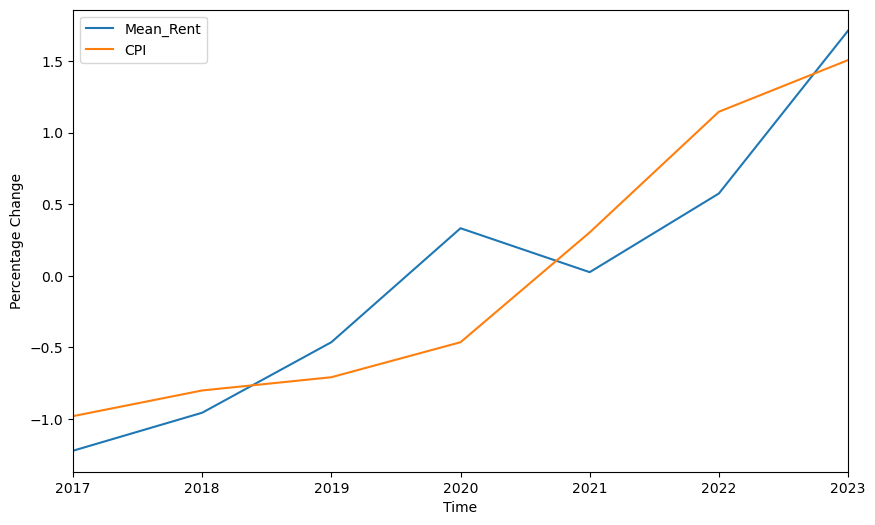

In [40]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Mean_Rent', estimated_lag=0, use_estimate=True)

The lag between the free market rate implemented and the consumer price index is:  2
The correlation Mean_Rent and consumer price index, after a 2 year lag is: 0.97


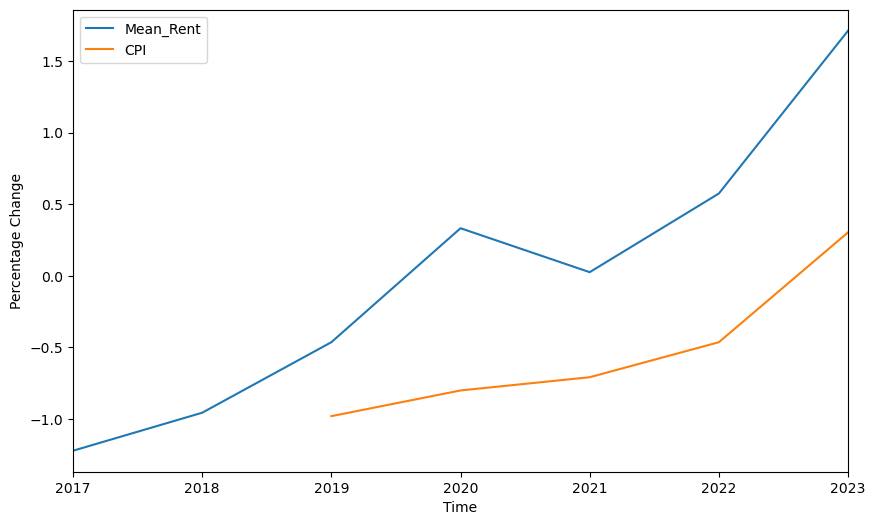

In [41]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Mean_Rent')

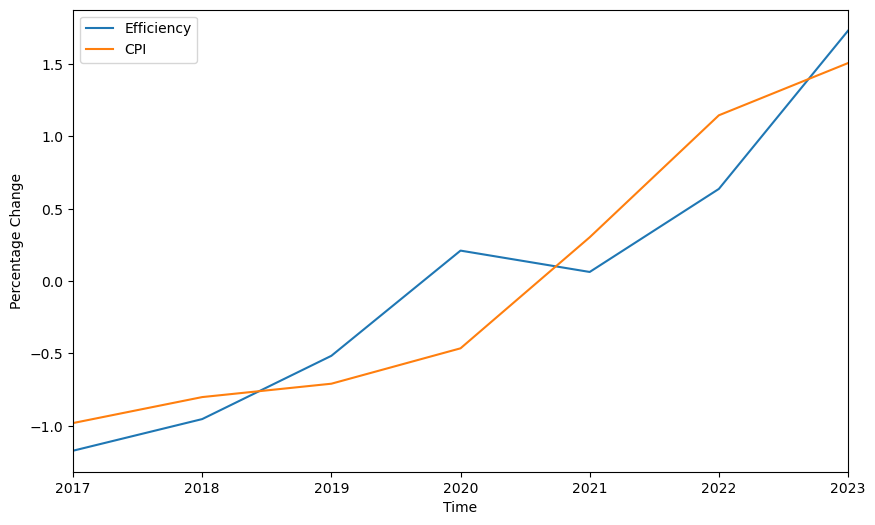

In [42]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Efficiency', estimated_lag=0, use_estimate=True)

The lag between the free market rate implemented and the consumer price index is:  2
The correlation Efficiency and consumer price index, after a 2 year lag is: 0.98


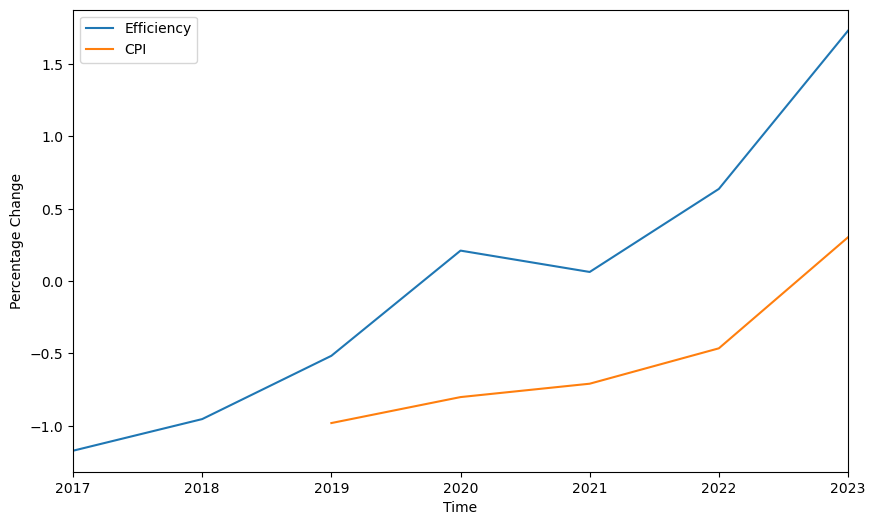

In [43]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Efficiency')

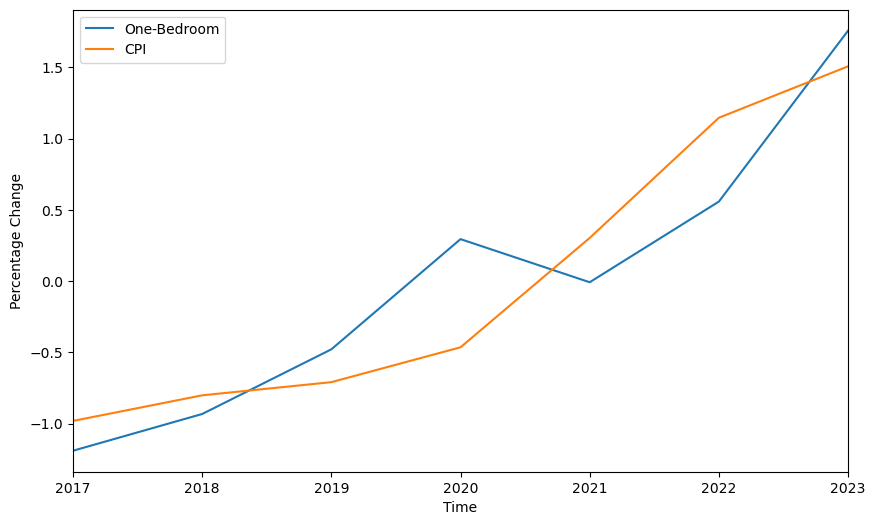

In [44]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='One-Bedroom', estimated_lag=0, use_estimate=True)

The lag between the free market rate implemented and the consumer price index is:  2
The correlation One-Bedroom and consumer price index, after a 2 year lag is: 0.97


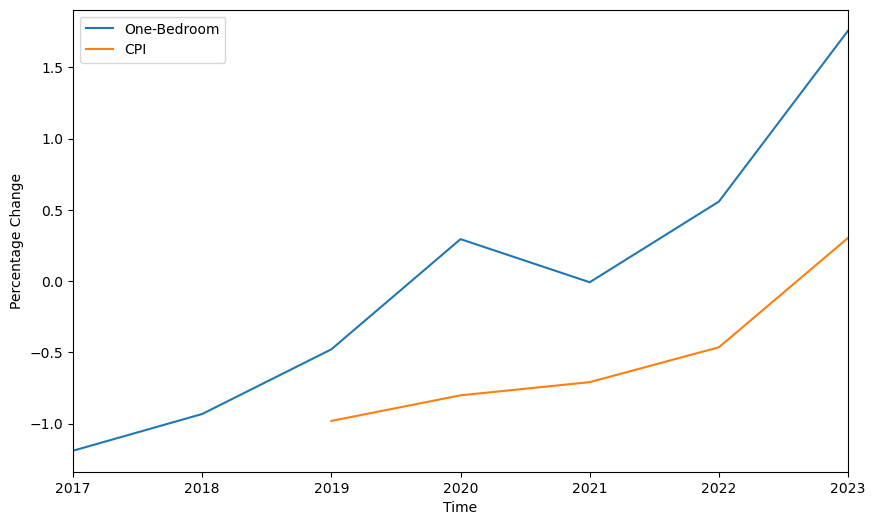

In [45]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='One-Bedroom')

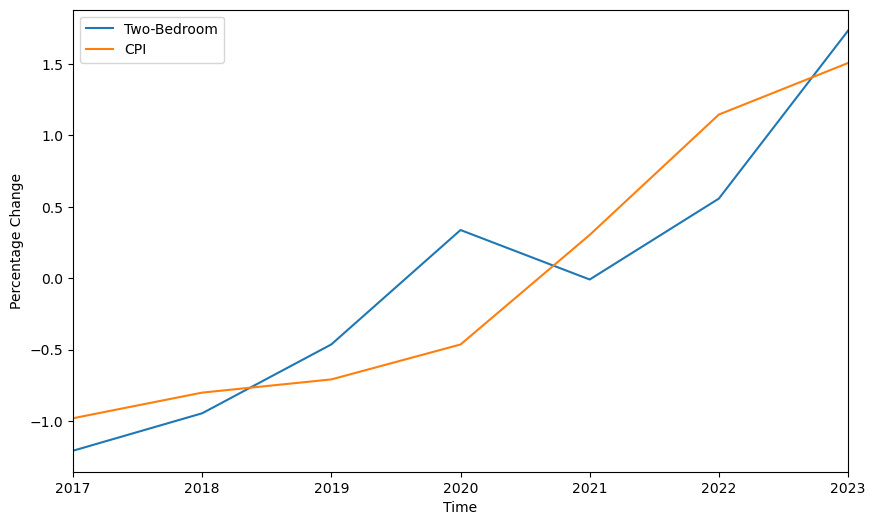

In [46]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Two-Bedroom', estimated_lag=0, use_estimate=True)

The lag between the free market rate implemented and the consumer price index is:  2
The correlation Two-Bedroom and consumer price index, after a 2 year lag is: 0.97


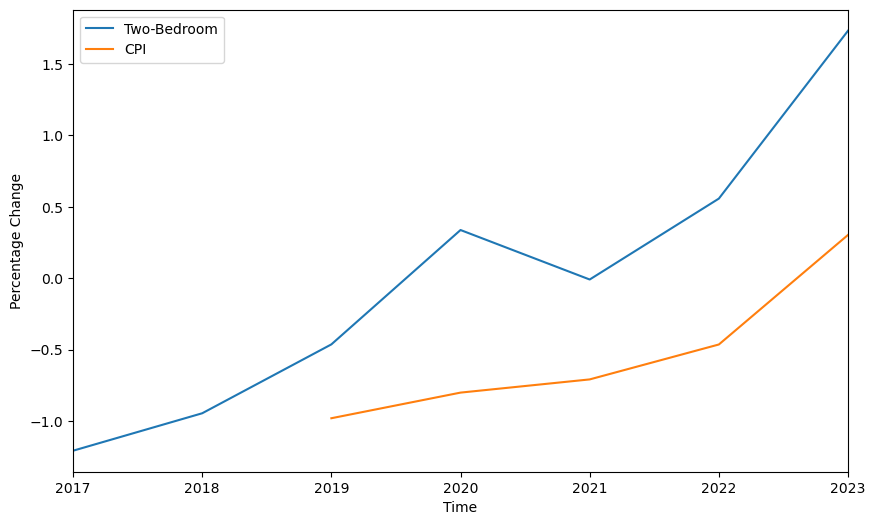

In [47]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Two-Bedroom')

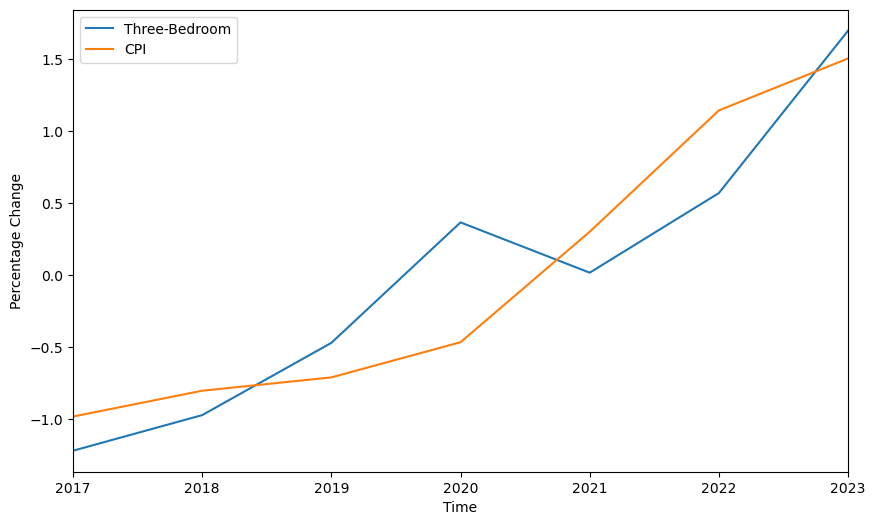

In [48]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Three-Bedroom', estimated_lag=0, use_estimate=True)

The lag between the free market rate implemented and the consumer price index is:  2
The correlation Three-Bedroom and consumer price index, after a 2 year lag is: 0.96


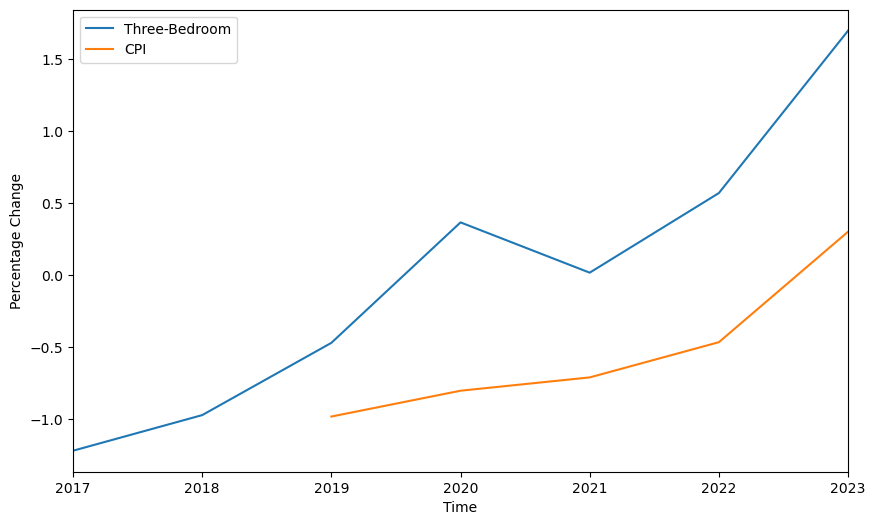

In [49]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Three-Bedroom')

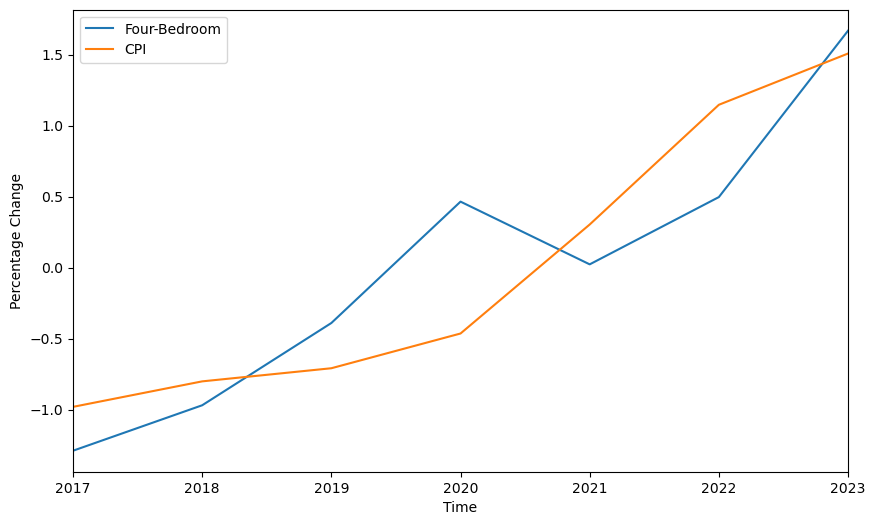

In [50]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Four-Bedroom', estimated_lag=0, use_estimate=True)

The lag between the free market rate implemented and the consumer price index is:  2
The correlation Four-Bedroom and consumer price index, after a 2 year lag is: 0.95


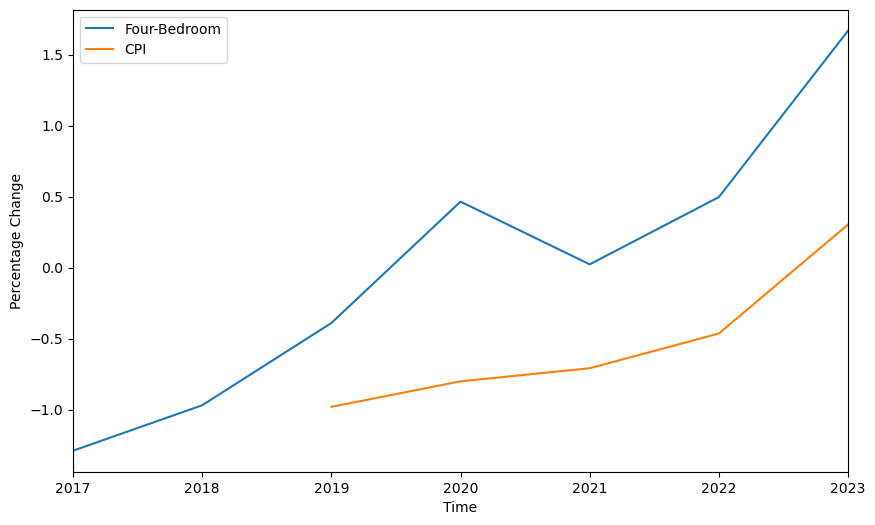

In [51]:
analyze.lag_calculator(combined_pct_std, field_to_analyze='Four-Bedroom')

The above graphs and correlation values provide a conclusive evidence that there is a two-year lag between the consumer price index of an area and the free market rate implemented in that area.

## Studying individual zipcodes in the metro area

In [52]:
# keeping jus the metro data
zipcode_data_metro = zipcode_data[zipcode_data['Metro_Codes'] ==  cbsa_code].drop(columns=['Metro_Codes']).reset_index(drop=True)
zipcode_data_metro.sort_values(['Date', 'ZIPCODE'], ascending=True, inplace=True)
zipcode_data_metro.head()

,ZIPCODE,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,Date,Mean_Rent
0,33010,570.0,720.0,920.0,1260.0,1500.0,2014-10-01,994.0
1,33011,680.0,860.0,1090.0,1490.0,1770.0,2014-10-01,1178.0
2,33012,670.0,850.0,1080.0,1480.0,1760.0,2014-10-01,1168.0
3,33013,620.0,780.0,990.0,1360.0,1610.0,2014-10-01,1072.0
4,33014,730.0,920.0,1170.0,1600.0,1900.0,2014-10-01,1264.0


### Identify Outliers

In [53]:
zips = analyze.zipcodes_trends(zipcode_data_metro, field_to_analyze='Mean_Rent')

In [109]:
zips[(zips['Above STD'] !=0 ) | (zips['Above STD'] != 0)]

,ZIPCODE,Above STD,Below STD,Total,Mean_growth_rate
0,33031,1,4,5,0.050433
1,33158,3,1,4,0.155407
2,33150,2,2,4,0.082980
3,33136,2,1,3,0.086403
4,33030,1,2,3,0.070889
5,33187,1,2,3,0.080024
6,33154,2,0,2,0.086272
7,33034,1,1,2,0.077022
8,33039,1,1,2,0.084710
9,33054,1,1,2,0.074719


In [110]:
zip_index = 0
zipcode = zips.loc[zip_index, 'ZIPCODE']
zipcode

'33031'

In [111]:
zip_data = zipcode_data[zipcode_data['ZIPCODE'] == zipcode]
zip_data = zip_data.drop(columns=['Metro_Codes', 'ZIPCODE']).set_index('Date')
zip_data.head()

,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,Mean_Rent
Date,,,,,,
2014-10-01,810.0,1010.0,1290.0,1770.0,2100.0,1396.0
2015-10-01,810.0,1010.0,1290.0,1770.0,2100.0,1396.0
2016-10-01,1090.0,1360.0,1720.0,2360.0,2800.0,1866.0
2017-10-01,1100.0,1360.0,1720.0,2360.0,2830.0,1874.0
2018-10-01,1100.0,1340.0,1700.0,2270.0,2740.0,1830.0


In [117]:
cbsa_data_t = zipcode_data_metro.drop(columns=['ZIPCODE']).groupby(['Date']).mean()
merge_zip = pd.merge(zip_data, cbsa_data_t, left_index=True, right_index=True, how='inner', suffixes=('_zip', '_metro'))
merge_zip = pd.merge(merge_zip, cpi_data_transformed, left_index=True, right_index=True, how='inner')
merge_zip

,Efficiency_zip,One-Bedroom_zip,Two-Bedroom_zip,Three-Bedroom_zip,Four-Bedroom_zip,Mean_Rent_zip,Efficiency_metro,One-Bedroom_metro,Two-Bedroom_metro,Three-Bedroom_metro,Four-Bedroom_metro,Mean_Rent_metro,CPI
Date,,,,,,,,,,,,,
2014-10-01,810.0,1010.0,1290.0,1770.0,2100.0,1396.0,725.252502,914.242432,1161.414185,1590.302979,1890.100952,1256.262573,244.130005
2015-10-01,810.0,1010.0,1290.0,1770.0,2100.0,1396.0,721.61615,910.0,1155.959595,1581.818237,1880.505005,1249.979858,246.789001
2016-10-01,1090.0,1360.0,1720.0,2360.0,2800.0,1866.0,804.141418,1000.808105,1264.54541,1739.090942,2061.01001,1373.919189,251.570999
2017-10-01,1100.0,1360.0,1720.0,2360.0,2830.0,1874.0,858.989929,1060.606079,1342.929321,1842.525269,2207.575684,1462.525269,258.455994
2018-10-01,1100.0,1340.0,1700.0,2270.0,2740.0,1830.0,948.888916,1162.727295,1472.727295,1961.414185,2370.404053,1583.2323,267.279999
2019-10-01,1150.0,1390.0,1760.0,2340.0,2850.0,1898.0,1030.808105,1242.222168,1576.262573,2098.484863,2553.636475,1700.282837,271.381012
2020-10-01,1310.0,1560.0,1970.0,2620.0,3180.0,2128.0,1175.252563,1393.737427,1762.222168,2348.080811,2844.444336,1904.747437,274.192993
2021-10-01,1280.0,1490.0,1880.0,2510.0,3010.0,2034.0,1156.262573,1350.404053,1703.737427,2271.01001,2731.515137,1842.585815,289.792999
2022-10-01,1160.0,1350.0,1700.0,2260.0,2710.0,1836.0,1250.404053,1434.343384,1801.31311,2394.242432,2841.313232,1944.323242,317.61499


In [125]:
merge_zip = merge_zip.pct_change()
merge_zip['CPI'] = merge_zip['CPI'].shift(2)

<Axes: xlabel='Date'>

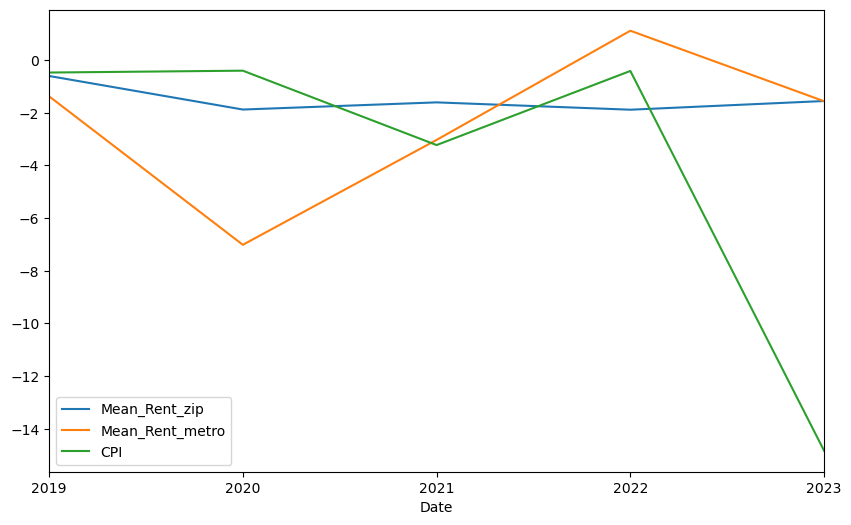

In [127]:
merge_zip[['Mean_Rent_zip','Mean_Rent_metro','CPI']].dropna().plot(kind='line', figsize=(10, 6))